## Description :
- Graph To uteract with a database using an Agent , main features :
   - Fetch the available tables from the database
   - Decide which tables are relevant to the question
   - Fetch the DDL for the relevant tables
   - Generate a query based on the question and information from the DDL
   - Double-check the query for common mistakes using an LLM
   - Execute the query and return the results
   - Correct mistakes surfaced by the database engine until the query is successful
   - Formulate a response based on the results

## Setup :

curl -fsSL https://ollama.com/install.sh | sh

ollama pull llama3-groq-tool-use:8b

ollama pull mistral-nemo:12b

ollama pull llama3.1:8b       `Not working with Function calling , but is amazing`

ollama pull codegeex4:latest  `Not working with Function calling , but is good at Code related tasks`

ollama pull nomic-embed-text  `For Embedding`



\

## Database Chinook.db

### Import Chinook.db

In [ ]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("/teamspace/studios/this_studio/LLM_Courses/Pratiques/Langraph/SQL Agent/Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

### Inteact with database:

In [1]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:////teamspace/studios/this_studio/LLM_Courses/Pratiques/Langraph/SQL Agent/Chinook.db")

In [2]:
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [3]:
result = db.run("SELECT * FROM Album;")
print(type(result))
print(result)

<class 'str'>
[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2), (3, 'Restless and Wild', 2), (4, 'Let There Be Rock', 1), (5, 'Big Ones', 3), (6, 'Jagged Little Pill', 4), (7, 'Facelift', 5), (8, 'Warner 25 Anos', 6), (9, 'Plays Metallica By Four Cellos', 7), (10, 'Audioslave', 8), (11, 'Out Of Exile', 8), (12, 'BackBeat Soundtrack', 9), (13, 'The Best Of Billy Cobham', 10), (14, 'Alcohol Fueled Brewtality Live! [Disc 1]', 11), (15, 'Alcohol Fueled Brewtality Live! [Disc 2]', 11), (16, 'Black Sabbath', 12), (17, 'Black Sabbath Vol. 4 (Remaster)', 12), (18, 'Body Count', 13), (19, 'Chemical Wedding', 14), (20, 'The Best Of Buddy Guy - The Millenium Collection', 15), (21, 'Prenda Minha', 16), (22, 'Sozinho Remix Ao Vivo', 16), (23, 'Minha Historia', 17), (24, 'Afrociberdelia', 18), (25, 'Da Lama Ao Caos', 18), (26, 'Acústico MTV [Live]', 19), (27, 'Cidade Negra - Hits', 19), (28, 'Na Pista', 20), (29, 'Axé Bahia 2001', 21), (30, 'BBC Sessions [Disc 1] [Live]'

## Discover Tools :

- We need 3 tools :
  - List_Tables     : tool to list the Tables Names of the Database.
  - Get_Schema      : tool to return the Schema of a Table(Table name, columns, types,...)
  - SQL_executer    : tool to execute the SQL query.
  - SQL_checker     : tool to check the query before execute it.
- All tools already developped by Langchain.

In [4]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(api_key="ollama",model="llama3.1:8b",base_url="http://localhost:11434/v1")

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

- SQLDatabaseToolkit() take an llm as arg because in the backend class, they should bea binding step, this is why we pass an LLM.

In [5]:
for tool in tools:
    print(f"Tool Name        : {tool.name}")
    print(f"Tool Description :{tool.description}")
    print(f"Tool arg schema  :{tool.args}\n")
    #print(dir(tool))
    if tool.name == "sql_db_list_tables":
        List_Tables = tool
    if tool.name == "sql_db_schema":
        Get_Schema = tool
    if tool.name == "sql_db_query":
        SQL_executer = tool


Tool Name        : sql_db_query
Tool Description :Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
Tool arg schema  :{'query': {'title': 'Query', 'description': 'A detailed and correct SQL query.', 'type': 'string'}}

Tool Name        : sql_db_schema
Tool Description :Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
Tool arg schema  :{'table_names': {'title': 'Table Names', 'description': "A comma-separated list of the table names for which to return the schema. Example input: 'table1, table2, table3'", 'type':

In [6]:
print(Get_Schema.invoke(List_Tables.invoke("")))


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES "Empl

In [7]:
print(List_Tables.invoke(""))
print(Get_Schema.invoke("Artist,Customer"))
print(SQL_executer("Select * from Customer limit 3"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")
)

/*
3 rows from Customer table:
CustomerId	FirstName	LastName	Company	Address	City	State	Country	PostalCode	Phone	Fax	Email	SupportRepId
1	Luís	Gonçalves	Embraer - Empresa Brasileira de Aeronáutica S.A.	Av. Brigadeiro F

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


- [Deffirence between db.run() and db.run_no_throw](https://api.python.langchain.com/en/latest/utilities/langchain_community.utilities.sql_database.SQLDatabase.html#langchain_community.utilities.sql_database.SQLDatabase.run_no_throw) 
- If an error is occured the first  return an an excption not handled so the Graph will stop execution, but the second return the error as  string message so the LLM can correct the query without breaking the Graph process.

In [8]:
db.run("Select * from Album Limit 10;")

"[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2), (3, 'Restless and Wild', 2), (4, 'Let There Be Rock', 1), (5, 'Big Ones', 3), (6, 'Jagged Little Pill', 4), (7, 'Facelift', 5), (8, 'Warner 25 Anos', 6), (9, 'Plays Metallica By Four Cellos', 7), (10, 'Audioslave', 8)]"

In [9]:
db.run_no_throw("Select * from Albu Limit 10;")

'Error: (sqlite3.OperationalError) no such table: Albu\n[SQL: Select * from Albu Limit 10;]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'

## Build LLMs:

### Chooser :

In [10]:
# Chooser LLM:

#from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
#from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing import Any
import ast


# LLM with Structered Output
llm = ChatOpenAI(api_key="ollama",model="llama3.1:8b",base_url="http://localhost:11434/v1")
#structured_llm_chooser = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at giving Tables Names that we need to get their schemas in order to respond to the user question.\n
Use the Tables Names we provide you and based on the question of the User you give us a  list of tables names we need to get 
their schemas in order to help anouther agent that will generate the SQL query.\n  
Don't add any additional details or explanations.\n 
Your response should be in forme of a list of names like "table1,table2..." """

chooser_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Give the Tables Names we need,Don't add any additional details or explanations just the Tables Names we need.\n\n The Tables Names here :\n {Tables_Names}\n\n The User qeustion here :\n {question} "),
    ]
)

"""
def convert_to_list(response: Any) -> Any:
    try:
        return ast.literal_eval(response.content)
    except (ValueError, SyntaxError):
        return []
"""     
Chooser = chooser_prompt | llm 

- Test

In [11]:
input = {"Tables_Names":List_Tables(""),"question":"Number of invoices per Customer ?"}
print(input)
response = Chooser.invoke(input)
print(response.content)

{'Tables_Names': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', 'question': 'Number of invoices per Customer ?'}
Invoice, Customer


### Generator :

In [12]:
# Generator LLM:

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# LLM with Structered Output
llm = ChatOpenAI(api_key="ollama",model="codegeex4:latest",base_url="http://localhost:11434/v1")
#structured_llm_chooser = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at generating SQL query.\n
Given the Tables Schemas and the User question you generate a correct and optimized sql query
that will respond to the user question.\n
Don't add any additional details or explanations just the SQL query.
Dont't add ```sql tag in your response"""

generator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Give the SQL query,Don't add any additional details or explanations just the SQL query and don't add ```sql tag.\n\n The Tables Schemas here :\n {Tables_Schemas}\n\n The User qeustion here :\n {question} ")
    ]
)
        
Generator = generator_prompt | llm

- Test

In [13]:
import pandas as pd 
import ast

def To_pandasDf(result :str):
    data_list = ast.literal_eval(result)
    df = pd.DataFrame(data_list)
    return df

In [14]:
input = {"Tables_Schemas":Get_Schema("Artist"),"question": "Count the number Artists in the Database ?"}
print(input)
response = Generator.invoke(input)
print(response.content.replace("```sql\n", "").replace("```", ""))

{'Tables_Schemas': '\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/', 'question': 'Count the number Artists in the Database ?'}
SELECT COUNT(*) AS TotalArtists FROM "Artist"


In [15]:
To_pandasDf(SQL_executer(response.content))

,0
0,275


### Evaluator :

In [16]:
# Evaluator LLM:

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# LLM with Structered Output
llm = ChatOpenAI(api_key="ollama",model="llama3.1:8b",base_url="http://localhost:11434/v1")
#structured_llm_chooser = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at evaluating SQL query.\n
Given the Tables Schemas,the User question and Sql query you evaluate the sql query if it's correct or not.\n
Your response should be Good/Bad key word.\n
Don't add any additional details or explanations just the key word."""

evaluator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "The Tables Schemas here :\n {Tables_Schemas}\n\n The User question here :\n {question}\n\n The Sql query here :\n {SQL_query} ")
    ]
)
        
Evaluator = evaluator_prompt | llm

- Test

In [17]:
input = {"Tables_Schemas":Get_Schema("Invoice,Customer"),
"question": "What are the details of invoices made by the customer with the email 'leonekohler@surfeu.de'?",
"SQL_query":"SELECT * FROM Invoice WHERE CustomerId in (SELECT CustomerId FROM Customer WHERE Email = 'leonekohler@surfeu.de')"}
print(input)
response = Evaluator.invoke(input)
print(response.content)

{'Tables_Schemas': '\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEGER, \n\tPRIMARY KEY ("CustomerId"), \n\tFOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")\n)\n\n/*\n3 rows from Customer table:\nCustomerId\tFirstName\tLastName\tCompany\tAddress\tCity\tState\tCountry\tPostalCode\tPhone\tFax\tEmail\tSupportRepId\n1\tLuís\tGonçalves\tEmbraer - Empresa Brasileira de Aeronáutica S.A.\tAv. Brigadeiro Faria Lima, 2170\tSão José dos Campos\tSP\tBrazil\t12227-000\t+55 (12) 3923-5555\t+55 (12) 3923-5566\tluisg@embraer.com.br\t3\n2\tLeonie\tKöhler\tNone\tTheodor-Heuss-Straße 34\tStuttgart\tNone\tGermany\t70174\t+49 0711 

## Initialize the Graph :

In [18]:
from typing_extensions import TypedDict
import pandas as pd
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    Question: str
    SQL_query: str
    Tables_Names: str
    Tables_Schemas: str
    Tables_Need: str
    Grade: str
    Finale_Response: pd.DataFrame

graph_builder = StateGraph(State)


## Build Nodes Functions:

In [19]:
from Colors import BLUE,RED,YELLOW,GREEN,RESET
import pandas as pd 
import ast

### Tools Functions :

In [20]:
def List_Tables_function(state:State):
    print(f"{YELLOW}List_Tables executing{RESET}")

    response = List_Tables.invoke("")
    return {"Tables_Names":response}

def Get_Schema_function(state:State):
    print(f"{YELLOW}Get_Schema executing{RESET}")

    response = Get_Schema.invoke(state["Tables_Need"])
    return {"Tables_Schemas":response}


def To_pandasDf(result :str):
    data_list = ast.literal_eval(result)
    df = pd.DataFrame(data_list)
    return df

def SQL_executer_function(state:State):
    print(f"{YELLOW}SQL_executer executing{RESET}")

    response = SQL_executer.invoke(state["SQL_query"])
    return {"Finale_Response": To_pandasDf(response)}

### LLMs Functions :

In [21]:
Num_Trials = 10

In [22]:
def Chooser_function(state:State):
    print(f"{GREEN}Chooser Thinking{RESET}")

    input = {"Tables_Names":state["Tables_Names"],"question":state["Question"]}
    response = Chooser.invoke(input)
    return {"Tables_Need":response.content}

def Generator_function(state:State):
    print(f"{GREEN}Generator Thinking{RESET}")

    input = {"Tables_Schemas": state["Tables_Schemas"],"question": state["Question"]}
    response = Generator.invoke(input)
    return {"SQL_query":response.content.replace("```sql\n", "").replace("```", "")}

def Evaluator_function(state:State):
    print(f"{GREEN}Evaluator Thinking{RESET}")
    input = {"Tables_Schemas":state["Tables_Schemas"],"question": state["Question"],"SQL_query":state["SQL_query"]}
    ############################## Vote Process
    num_of_good = 0
    for i in range(Num_Trials):
        response = Evaluator.invoke(input)
        if "good" in response.content.lower():
            num_of_good +=1
    print(f"{GREEN}Num of Good : {num_of_good} {RED} Num of Bad {Num_Trials-num_of_good}{RESET}")
    ################################
    if num_of_good > Num_Trials-num_of_good:
        return {"Grade":"Good"}
    return {"Grade":"Bad"}

### Conditional functions :

In [23]:
def Grade(state:State)->str:
    if state["Grade"] == "Good":
        return "execute"
    return "End"

## Design The Graph:

### Build The SQL_Graph:

In [24]:
graph_builder.add_node("List_Tables",List_Tables_function)
graph_builder.add_node("Chooser",Chooser_function)
graph_builder.add_node("Get_Schema",Get_Schema_function)
graph_builder.add_node("Generator",Generator_function)
graph_builder.add_node("Evaluator",Evaluator_function)
graph_builder.add_node("SQL_Executer",SQL_executer_function)

In [25]:
graph_builder.add_edge(START,"List_Tables")
graph_builder.add_edge("List_Tables","Chooser")
graph_builder.add_edge("Chooser","Get_Schema")
graph_builder.add_edge("Get_Schema","Generator")
graph_builder.add_edge("Generator","Evaluator")
graph_builder.add_conditional_edges("Evaluator",Grade,{"End":"__end__","execute":"SQL_Executer"})

In [26]:
SQL_Graph = graph_builder.compile()

### Visualize Our Graph:

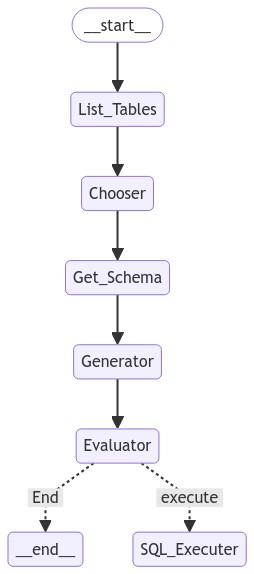

In [27]:
from IPython.display import Image, display

try:
    display(Image(SQL_Graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Interact with The Graph :

In [28]:
# Run
inputs = {
    "Question": "Which customers are supported by the employee with the first name 'Jane'?" +"be accurate and Optimale"
}
for output in SQL_Graph.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node :{key}")
        print(f"State :{value}")
    print("\n")

value["Finale_Response"]

List_Tables executing
Node :List_Tables
State :{'Tables_Names': 'Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track'}


Chooser Thinking
Node :Chooser
State :{'Tables_Need': 'Employee, Customer'}


Get_Schema executing
Node :Get_Schema
State :{'Tables_Schemas': '\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEGER, \n\tPRIMARY KEY ("CustomerId"), \n\tFOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")\n)\n\n/*\n3 rows from Customer table:\nCustomerId\tFirstName\tLastName\tCompany\tAddress\tCity\tState\tCountry\tPostalCode\tPhone\tFax\tEmail\tSupportRepId\n1\tLuí

Warning: You can only execute one statement at a time.

## Evaluation Using GPT-4o
- I use GPT-4o to generate user questions with the coresponding SQL query, so we can test Our Graph.

In [ ]:
GPT4_query = """SELECT e.FirstName, e.LastName
FROM Customer c
JOIN Employee e ON c.SupportRepId = e.EmployeeId
WHERE c.FirstName = 'François' AND c.LastName = 'Tremblay';

"""
To_pandasDf(SQL_executer(GPT4_query))